**WARNING**: Remember to run the `ExtractBoundaries` notebook present in this same folder before running all (or specifically the `Import Boundaries` cell)

In [1]:
SAVE_ON_DRIVE = True # Set to True if you want to save the datasets and trained models to your Google Drive
TYPE = 'Train'

# Dataset initialization


### Download Data

In [2]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive')

# Set paths for Validation and Test datasets
val_dataset_path = '/content/drive/MyDrive/LoveDA/Val'
test_dataset_path = '/content/drive/MyDrive/LoveDA/Test'


# Function to handle dataset download and extraction
def handle_dataset(dataset_name, zip_url, local_path, drive_path):
    if not os.path.exists(local_path):
        if os.path.exists(f"{drive_path}.zip"):
            print(f"{dataset_name} dataset available on own drive, unzipping...")
            !unzip -q {drive_path}.zip -d ./
        else:
            print(f"Downloading {dataset_name} dataset...")
            !wget -O {dataset_name}.zip "{zip_url}"
            if SAVE_ON_DRIVE:
                print(f"Saving {dataset_name} dataset on drive...")
                !cp {dataset_name}.zip {drive_path}.zip
                print(f"{dataset_name} dataset saved on drive")
            print(f"Unzipping {dataset_name} dataset...")
            !unzip -q {dataset_name}.zip -d ./
    else:
        print(f"{dataset_name} dataset already in local")

# Handle Validation dataset
#handle_dataset("Validation", "https://zenodo.org/records/5706578/files/Val.zip?download=1", "./Val", "/content/drive/MyDrive/LoveDA/Val")

# Handle Test dataset
#handle_dataset("Test", "https://zenodo.org/records/5706578/files/Test.zip?download=1", "./Test", "/content/drive/MyDrive/LoveDA/Test")

# Handle Train dataset
handle_dataset("Train", "https://zenodo.org/records/5706578/files/Train.zip?download=1", "./Train", "/content/drive/MyDrive/LoveDA/Train")

Mounted at /content/drive
Train dataset available on own drive, unzipping...


### Import Boundaries

In [3]:
# Paths
rural_boundaries_path = "./Train/Rural/boundaries_png"
rural_masks_path = './Train/Rural/masks_png'

urban_boundaries_path = "./Train/Urban/boundaries_png"
urban_masks_path = './Train/Urban/masks_png'
drive_rural_boundaries_path = '/content/drive/MyDrive/LoveDA/boundaries/Rural/boundaries_png'
drive_urban_boundaries_path = '/content/drive/MyDrive/LoveDA/boundaries/Urban/boundaries_png'

boundaries_paths = [rural_boundaries_path, urban_boundaries_path]

# Make dir inside ./Train/...
for boundaries_path in boundaries_paths:
    if (os.path.exists(boundaries_path) == False):
        print(f"Creating {boundaries_path}...")
        os.makedirs(boundaries_path)
    else:
        print(f"{boundaries_path} exists...")


# Check if files are already present
rural_file_count = len([name for name in os.listdir(rural_boundaries_path) if os.path.isfile(os.path.join(rural_boundaries_path, name))])
rural_mask_file_count = len([name for name in os.listdir(rural_masks_path) if os.path.isfile(os.path.join(rural_masks_path, name))])
urban_file_count = len([name for name in os.listdir(urban_boundaries_path) if os.path.isfile(os.path.join(urban_boundaries_path, name))])
urban_mask_file_count = len([name for name in os.listdir(urban_masks_path) if os.path.isfile(os.path.join(urban_masks_path, name))])

# if (rural_file_count != rural_mask_file_count):
#     print(f"Importing boundaries, as we have {rural_file_count} rural boundaries as of now...")
#     shutil.copytree(drive_rural_boundaries_path, rural_boundaries_path, dirs_exist_ok=True)
# else:
#     print(f"Rural boundaries already present, {rural_file_count} files...")

if (urban_file_count != urban_mask_file_count):
    print(f"Importing boundaries, as we have {urban_file_count} urban boundaries as of now...")
    shutil.copytree(drive_urban_boundaries_path, urban_boundaries_path, dirs_exist_ok=True)
else:
    print(f"Urban boundaries already present, {urban_file_count} files...")

Creating ./Train/Rural/boundaries_png...
Creating ./Train/Urban/boundaries_png...
Importing boundaries, as we have 0 urban boundaries as of now...


### Dataset Definition

In [4]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import random
import cv2


def pil_loader(path, color_type):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert(color_type)

class LoveDADataset(Dataset):
    def __init__(self, baseTransform, augTransforms, split = 'Urban', type = 'Train', useBoundaries=True, validation_ratio=0.2, seed=265637):
        # Validate type input
        if type not in ['Train', 'Validation', 'Total', 'ActualTest']:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation' or 'Total' or 'ActualTest'.")
        self.directory = []
        if type == 'ActualTest':
            directory_path = os.path.join('./Validation', split, 'images_png')
        else:
            directory_path = os.path.join('./Train', split, 'images_png')
        # Check if the directory exists
        if not os.path.exists(directory_path):
            raise FileNotFoundError(f"Directory not found: {directory_path}")
        # Get all image paths
        all_images = [os.path.join(directory_path, entry) for entry in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, entry))]
        # Shuffle images for random splitting
        random.seed(seed)
        random.shuffle(all_images)
        # Split into training and validation sets
        split_idx = int(len(all_images) * (1 - validation_ratio))
        if type == 'Train':
            self.directory = all_images[:split_idx]
        elif type == 'Validation':
            self.directory = all_images[split_idx:]
        elif type == 'Total':
            self.directory = all_images
        elif type == 'ActualTest':
            self.directory = all_images
        else:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation' or 'Total' or 'ActualTest.")
        self.baseTransforms = baseTransform
        self.augTransforms = augTransforms
        self.useBoundaries = useBoundaries
        self.typeDataset = type
        # Print dataset size
        print(f"Dataset size: {len(self.directory)}")

    def __len__(self):
        return len(self.directory)

    def __getitem__(self, idx):
        image_path = self.directory[idx]
        image = pil_loader(image_path, 'RGB')
        mask_path = image_path.replace('images_png', 'masks_png')
        boundaries_path = image_path.replace('images_png', 'boundaries_png')

        mask = pil_loader(mask_path, 'L')

        if self.useBoundaries:
          boundaries = pil_loader(boundaries_path, 'L')
        else:
          boundaries = mask

        base_transformed = self.baseTransforms(image=np.array(image), mask=np.array(mask), boundaries=np.array(boundaries))
        base_image = base_transformed['image']
        base_mask = base_transformed['mask']
        base_boundaries = base_transformed['boundaries']

        base_image = T.Compose([T.ToTensor()])(base_image)
        base_mask = torch.from_numpy(base_mask).long()
        base_mask -= 1
        base_boundaries = torch.from_numpy(base_boundaries)

        if(self.typeDataset != 'Train'):
          return base_image, base_mask, image_path, base_boundaries


        if self.augTransforms == None:
          return [base_image], [base_mask], image_path, [base_boundaries]
        # Apply transformations
        augmented = self.augTransforms(image=np.array(image), mask=np.array(mask), boundaries=np.array(boundaries))
        augmented_image = T.Compose([T.ToTensor()])(augmented['image'])

        mask = augmented['mask']
        mask = torch.from_numpy(mask).long()
        mask = mask-1
        boundaries = augmented['boundaries']
        boundaries = torch.from_numpy(boundaries)

        image_list = [base_image, augmented_image]
        mask_list = [base_mask, mask]
        boundaries_list = [base_boundaries, boundaries]

        return image_list, mask_list, image_path, boundaries_list

### Dataset Utils

In [5]:
import matplotlib.patches as mpatches

from collections import OrderedDict
COLOR_MAP = OrderedDict(
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(34, 139, 34),
    Agricultural=(255, 195, 128),
)

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6,
)
inverted_label_map = OrderedDict((v, k) for k, v in LABEL_MAP.items())


def getLabelColor(label):
    # Default color for unclassified labels
    default_color = np.array([128, 128, 128])  # Gray

    # Check if label exists in inverted_label_map
    label_name = inverted_label_map.get(label, None)
    if label_name is None or label_name not in COLOR_MAP:
        return default_color  # Return default color for unclassified

    # Return the mapped color
    label_color = np.array(COLOR_MAP[label_name])
    return label_color


def getLegendHandles():
  handles = [mpatches.Patch(color=getLabelColor(i)/255, label=inverted_label_map[i]) for i in range(0, len(LABEL_MAP))]
  handles.append(mpatches.Patch(color=getLabelColor(-1)/255, label='Unclassified'))
  return handles

def new_colors_mask(mask):
  new_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
  for i, row in enumerate(mask):
    for j, cell in enumerate(row):
      new_image[i][j] = getLabelColor(cell.item())
  return new_image



### Dataset Debug

In [6]:
# # Comment this cell to save GPU time

# import matplotlib.pyplot as plt
# import torch
# from torch.utils.data import DataLoader
# import matplotlib.patches as mpatches

# train_dataset = LoveDADataset(type='Train', seed=222)
# print(train_dataset.__len__())

# # Get item
# image, mask, path, bd = train_dataset.__getitem__(88)

# # Show path
# print(f"Image is at {path}")

# # Show image
# image = image.permute(1, 2, 0)
# image = image.numpy()
# plt.imshow(image)

# # Show mask
# new_image = new_colors_mask(mask)
# plt.imshow(image)
# plt.show()
# plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
# plt.imshow(new_image)
# plt.show()

# # Show boundaries
# # for row in bd:
# #     for col in row:
# #         if col != 0 and col != 1:
# #             print(col)
# bd = bd.numpy()
# plt.imshow(bd)


# Initialize model

### PIDNet Util Modules

In [7]:
# ------------------------------------------------------------------------------
# Written by Jiacong Xu (jiacong.xu@tamu.edu)
# ------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)



### PIDNet Definition

In [8]:
# ------------------------------------------------------------------------------
# Written by Jiacong Xu (jiacong.xu@tamu.edu)
# ------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

INPUT_SIZE = (512, 512)

class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        h, w = x.size(2), x.size(3)

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model




### Discriminator Model

In [9]:
# Remember to upsample the input x before running it through this, as the paper says
import torch
import torch.nn as nn
import torch.nn.init as init


class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.domain_classifier = nn.Sequential(
            nn.Conv2d(num_classes, 64, kernel_size=4, stride=2, padding=1),  # Conv1
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Conv2
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Conv3
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Conv4
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1),  # Conv5
        )

    def forward(self, x):
        return self.domain_classifier(x)

# Initialize the model with Kaiming initialization
def initialize_weights_kaiming(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
        if m.bias is not None:
            init.zeros_(m.bias)

### Load PIDNet Model

In [10]:
import gdown
import tarfile

if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)
# Then keep as tar, as it's already the correct format to feed the model

# Create a config object with required parameters
class Config:
    class MODEL:
        NAME = 'pidnet_s'  # or 'pidnet_m' or 'pidnet_l'
        PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
    class DATASET:
        NUM_CLASSES = len(LABEL_MAP)

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)
# model = get_pred_model('s', len(LABEL_MAP))

disc_model = Discriminator(len(LABEL_MAP))
disc_model.apply(initialize_weights_kaiming)

def monitor_bn_stats(module, input, output):
  if isinstance(module, torch.nn.BatchNorm2d):
    running_mean = module.running_mean.cpu().detach().numpy()
    running_var = module.running_var.cpu().detach().numpy()
    print(f"Running mean: {running_mean}")
    print(f"Running variance: {running_var}")

# for name, module in model.named_modules():
#     if isinstance(module, torch.nn.BatchNorm2d):
#         module.register_forward_hook(monitor_bn_stats)


Downloading...
From: https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-
To: /content/PIDNet_S_ImageNet.pth.tar
100%|██████████| 38.1M/38.1M [00:01<00:00, 30.6MB/s]
<ipython-input-8-793b5191e8fb>:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.

### Model Debugging

In [11]:
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt

# train_dataset = LoveDADataset(type='Train')
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

# model = model.train()
# model = model.to('cuda')

# for img, mask, _ in train_loader:
#     print(f"iamge shape: {img.shape}")
#     print(f"mask shape: {mask.shape}")

#     img = img.to('cuda')
#     outputs = model(img)

#     # bilinear interpolation
#     h, w = mask.size(1), mask.size(2)
#     ph, pw = outputs[0].size(2), outputs[0].size(3)
#     if ph != h or pw != w:
#         for i in range(len(outputs)):
#             outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear',
#                                        align_corners=True)

#     for output in outputs:
#       print(output.shape)
#     break

# print("===================== Original Image =====================")
# plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
# plt.show()

# print("===================== Ground Truth =====================")
# plt.imshow(mask[0].cpu().numpy())
# plt.show()

# print("===================== Predicted Mask =====================")
# plt.imshow(torch.argmax(outputs[0][0], dim=0).cpu().numpy())
# plt.show()

# Training & Dataset creation

### Hyperparams, Ablations, Macros

In [12]:
################################################################################
# Macros
DEVICE = 'cuda' # 'cuda' or 'cpu'
LOG_FREQUENCY = 5
NUM_CLASSES = len(LABEL_MAP)

################################################################################
# Hyperparams To Ablate

LR = 1e-4        # The initial Learning Rate -- I increased it using quadratic rule in relation with batch size
DISC_LR = 5e-4  #1e-4   # The initial Learning Rate for Discriminator
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 21     # How many epochs before decreasing learning rate (if using a step-down policy) -- Trying to keep a 2:3 ratio with NUM_EPOCHS
DISC_STEP_SIZE = 21
# STEP_SIZEs = [21, 14]
# DISC_STEP_SIZEs = [14, 21]
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

BATCH_SIZE = 24

LAMBDA_SEG = 1
LAMBDA_ADVs = [1e-4]
LAMBDA_DISC = 0.1

DO_SPIKECHARGE = False

FREEZE_PIDNET_COMPLETELY_WHEN_TRAINING_DISCRIMINATOR = False

#VALIDATE_ON_WHAT = 'PID+ADV+DISC' # 'PID+ADV+DISC' or 'PID+RuralGT'

LOAD_BASE_MODEL = True
drive_path = '/content/drive/MyDrive/LoveDA/Augmentations'
model_name = 'best_model_PIDNET_Jitter+RotateFlip+Resize.pth'
################################################################################
# Other Macros

SAVE_AFTER_EPOCH = 19 # Keep this between 15 and 18 maybe, since the "best" model (the one with minimal overall loss) is often not the best in mIoU
TEST_ONLY_ON_BEST = False # Leave False unless you're really picky/in need of time
TEST_MODELS_FROM_MYDRIVE_TOO = False
INTEREST = "False"

### Augmentations/Transforms

In [13]:
from albumentations import Compose, HorizontalFlip, RandomRotate90, RandomScale, RandomCrop, GaussNoise, Rotate, Resize, OneOf, Normalize, ColorJitter, GaussianBlur
from albumentations.pytorch import ToTensorV2

#How big should be the image that we feed to the model?
RESIZE = 512
# DEFINE TRANSFORMATIONS HERE
# To Tensor is not needed since its performed inside the getitem


AUGMENTATIONS = {
    'Resize': Compose([
            Resize(RESIZE, RESIZE),
    ], additional_targets={"boundaries": "mask"}),
    'Jitter+RotateFlip+Resize': Compose([
        ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
        OneOf([
            HorizontalFlip(p=0.5),
            RandomRotate90(p=0.5),
        ], p=0.5),
        Resize(RESIZE, RESIZE),
        ], additional_targets={"boundaries": "mask"}),

}

CHOOSE_TRANSFORM = 'Jitter+RotateFlip+Resize' # The dictionary key for the base transform
AUGTRANSFORM = None         # The transform object itself for the extra transform

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Setup, Create Datasets and DataLoaders. With annexed transforms.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

## Dataset and Loader
# Training Sets and Loaders
source_dataset = LoveDADataset(baseTransform=AUGMENTATIONS[CHOOSE_TRANSFORM], augTransforms=AUGTRANSFORM, split='Urban', type='Train', validation_ratio=0.2)
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)

target_dataset = LoveDADataset(baseTransform=AUGMENTATIONS[CHOOSE_TRANSFORM], augTransforms=AUGTRANSFORM, split='Rural', type='Train', validation_ratio=0.2, useBoundaries=False)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)

# Validation Sets and Loaders
source_validation_dataset = LoveDADataset(baseTransform=AUGMENTATIONS['Resize'], augTransforms=None, split='Urban', type='Validation', validation_ratio=0.2, useBoundaries=False)
source_validation_loader = DataLoader(source_validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)

target_validation_dataset = LoveDADataset(baseTransform=AUGMENTATIONS['Resize'], augTransforms=None, split='Rural', type='Validation', validation_ratio=0.2, useBoundaries=False)
target_validation_loader = DataLoader(target_validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)

## Model is defined some cells above, in LoadPidNetModel
# Now load its weights
if LOAD_BASE_MODEL:
  model_path = os.path.join(drive_path, model_name)
  print(f"LOADING {model_path}")
  best_model = torch.load(model_path, map_location=DEVICE)
  model.load_state_dict(best_model)

## Optimizier and Scheduler
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

disc_optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=DISC_LR, betas=(0.9, 0.99))
disc_scheduler = optim.lr_scheduler.StepLR(disc_optimizer, step_size=DISC_STEP_SIZE, gamma=GAMMA)

<ipython-input-14-439b882fa156>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(model_path, map_location=DEVICE)


Dataset size: 924
Dataset size: 1092
Dataset size: 232
Dataset size: 274
LOADING /content/drive/MyDrive/LoveDA/Augmentations/best_model_PIDNET_Jitter+RotateFlip+Resize.pth


### Losses

In [15]:
def weighted_bce(bd_pre, target):
    n, c, h, w = bd_pre.size()
    log_p = bd_pre.permute(0,2,3,1).contiguous().view(1, -1)
    target_t = target.view(1, -1)

    pos_index = (target_t == 1)
    neg_index = (target_t == 0)

    weight = torch.zeros_like(log_p)
    pos_num = pos_index.sum()
    neg_num = neg_index.sum()
    sum_num = pos_num + neg_num
    weight[pos_index] = neg_num * 1.0 / sum_num
    weight[neg_index] = pos_num * 1.0 / sum_num

    loss = F.binary_cross_entropy_with_logits(log_p, target_t, weight, reduction='mean')

    return loss

def boundary_loss(bd_pre, bd_gt):
    loss = 20.0 * weighted_bce(bd_pre, bd_gt)
    return loss

# TODO EXTRA add weights=class_weights to nn.CrossEntropyLoss()
# TODO EXTRA use OHCE instead of basic one
def cross_entropy(score, target):
    compute_ce_loss = nn.CrossEntropyLoss(ignore_index=-1)

    # See paper for weights. In order of loss index: (0.4, 20, 1, 1) # But on cfg they set everything to 0.5
    balance_weights = [0.4, 1]
    sb_weights = 1

    # print(f"DEBUG: inside cross_entropy: len(score) = {len(score)}")
    if len(balance_weights) == len(score):
        return sum([w * compute_ce_loss(x, target) for (w, x) in zip(balance_weights, score)])
    elif len(score) == 1:
        return sb_weights * compute_ce_loss(score[0], target)
    else:
        raise ValueError("lengths of prediction and target are not identical!")

sem_loss = cross_entropy
bd_loss = boundary_loss
bce_loss = torch.nn.BCEWithLogitsLoss()

### Training Loop

In [16]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import numpy as np

# For easier debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

TYPE = 'Train'


for LAMBDA_ADV in LAMBDA_ADVs:
    charge = 0
    spike_disc = 0
    spike_pidnet = 0
    SAVE_MODEL_AS = f'best_DA_model_LA={LAMBDA_ADV}_LD={LAMBDA_DISC}_LRdisc={DISC_LR}_usespike={DO_SPIKECHARGE}_s={spike_disc}_spid={spike_pidnet}.pth'
    SAVE_DISC_MODEL_AS = f'best_disc_model_{CHOOSE_TRANSFORM}_LS={LAMBDA_SEG}_LA={LAMBDA_ADV}_LD={LAMBDA_DISC}.pth'
    MODEL_NAME = SAVE_MODEL_AS

    current_step = 0

    best_loss = float('inf')
    best_model = model.state_dict()
    disc_best_model = disc_model.state_dict()

    model = model.to(DEVICE)
    disc_model = disc_model.to(DEVICE)
    print(f"DEVICE is {DEVICE}. Loss scales are: LAMBDA_SEG={LAMBDA_SEG}, LAMBDA_ADV={LAMBDA_ADV}, LAMBDA_DISC={LAMBDA_DISC}")

    plot_losses = {
        'adv' : [],
        'disc' : [],
        'complete' : [],
        'pidnet' : [],
    }

    batch_losses = {
        'adv' : [],
        'disc' : [],
        'complete' : [],
        'pidnet' : [],
    }


    objective = 'discriminator'
    best_mIoU_s = 0

    #mIoU before
    model.eval()
    total_union_t = torch.zeros(NUM_CLASSES).to(DEVICE)
    total_intersection_t = torch.zeros(NUM_CLASSES).to(DEVICE)
    total_union_s = torch.zeros(NUM_CLASSES).to(DEVICE)
    total_intersection_s = torch.zeros(NUM_CLASSES).to(DEVICE)
    with torch.no_grad():
        for batch_i, batch_s in tqdm(enumerate(source_validation_loader)):
            images, masks, _, bd_gts = batch_s
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            bd_gts = bd_gts.float().to(DEVICE)
            outputs = model(images)
            h, w = masks.size(1), masks.size(2)
            ph, pw = outputs[0].size(2), outputs[0].size(3)
            if ph != h or pw != w:
                for i in range(len(outputs)):
                    outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

            ### ========> Calculate mIoU
            ## mIoU on source
            class_indices_s = torch.argmax(outputs[1], dim=1)

            for predicted, target in zip(class_indices_s, masks):
                for i in range(NUM_CLASSES):
                    total_intersection_s[i] += torch.sum(torch.logical_and(predicted == i, target == i))
                    total_union_s[i] += torch.sum(torch.logical_or(predicted == i, target == i))

    intersection_over_union_s = total_intersection_s / total_union_s
    mIoU_s = torch.mean(intersection_over_union_s)
    print(f"mIoU on source before training: {mIoU_s}")


    if TYPE == 'Train':
        for epoch in range(NUM_EPOCHS):
            model.train()
            disc_model.train()

            epoch_losses = {
                'loss_complete': 0.0,
                'amount': 0, # amt of images I think?
                'loss_pidnet': 0.0,
                'loss_adv': 0.0,
                'loss_disc': 0.0,
                'loss_pidnet_wtd': 0.0,
                'loss_adv_wtd': 0.0,
                'loss_disc_wtd': 0.0,
            }

            print('Starting epoch {}/{}, LR = {}, DISC_LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr(), disc_scheduler.get_lr()))
            srcldr_len = len(source_loader)
            tgtldr_len = len(target_loader)
            print(f"len of source_loader is {srcldr_len}, len of target_loader is {tgtldr_len}. WARNING: make sure source is shorter than target, or modify code to fix early stopping")

            # ================================== Train Epoch X ==================================
            for batch_i, (batch_s, batch_t) in tqdm(enumerate(zip(source_loader, target_loader)), total=len(source_loader)):
                optimizer.zero_grad()
                disc_optimizer.zero_grad()

                ### Extract input
                image_list_source, masks_list_source, img_path_source, bd_gts_list_source = batch_s
                image_list_target, _, _, _ = batch_t

                index = 0
                for images, masks, bd_gts, images_t in zip(image_list_source, masks_list_source, bd_gts_list_source, image_list_target):
                    ### Extract Images, Masks, Boundaries
                    # Source
                    images = images.to(DEVICE)
                    masks = masks.to(DEVICE)
                    bd_gts = bd_gts.float().to(DEVICE)
                    # Target
                    images_t = images_t.to(DEVICE)

                    ### ReEnable optimization on backbone (***PIDNet***)
                    if DO_SPIKECHARGE == True:
                        if objective == 'pidnet':
                            model = model.train()
                            disc_model = disc_model.eval()
                            for param in model.parameters():
                                param.requires_grad = True
                            for param in disc_model.parameters():
                                param.requires_grad = False
                        else:
                            model = model.eval()
                            disc_model = disc_model.train()
                            for param in disc_model.parameters():
                                param.requires_grad = True
                            for param in model.parameters():
                                param.requires_grad = False
                    else:
                        model = model.train()
                        disc_model = disc_model.eval()
                        for param in model.parameters():
                            param.requires_grad = True
                        for param in disc_model.parameters():
                            param.requires_grad = False

                    ### ===> Train Segmentation --- on Source
                    ## Forward
                    outputs = model(images) # in model.train() mode batch size must be > 1 I think
                                            # NOTE: we have 3 heads (i.e. 3 outputs) but 4 losses: 2nd head is used for both S and BAS

                    ## Upscale (bilinear interpolation - not learned)
                    h, w = masks.size(1), masks.size(2)
                    ph, pw = outputs[0].size(2), outputs[0].size(3)
                    if ph != h or pw != w:
                        for i in range(len(outputs)):
                            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

                    ## Losses
                    # Semantic Losses (l_0 and l_2)
                    loss_s = sem_loss(outputs[:-1], masks) # output #1 and #2 are segmentation predictions (i.e. low level (P) and high+low level (PI) respectively)

                    # Boundary Loss (l_1)
                    loss_b = bd_loss(outputs[-1], bd_gts) # output #3 is the boundary prediction

                    # Boundary AwareneSS (BAS) Loss (l_3)
                    filler = torch.ones_like(masks) * -1
                    bd_label = torch.where(F.sigmoid(outputs[-1][:,0,:,:]) > 0.8, masks, filler)
                                        # REMEMBER to wrap in list, as the checks in ce use that to know what to do
                    loss_sb = sem_loss([outputs[-2]], bd_label) # output #2 is the PI segmentation prediction, done here in BAS mode (see `filler` variable)

                    # Segmentation Loss w/o DA (on source domain, which has labels)
                    loss_pidnet = loss_s + loss_b + loss_sb  # The coefficients of the sum of the four losses (0.4, 20, 1, 1) are taken into account in the various `sem_loss` and `bd_loss`
                    if batch_i % LOG_FREQUENCY == 0:
                        print(f'\n[losses are unscaled] loss_pidnet at batch {batch_i}: {loss_pidnet.item():.4f}', end=" --- ")
                    epoch_losses['loss_pidnet'] += loss_pidnet.item()


                    loss = loss_pidnet * LAMBDA_SEG
                    epoch_losses['loss_complete'] += loss.item()
                    epoch_losses['loss_pidnet_wtd'] += loss.item()

                    batch_losses['pidnet'].append(loss.item())
                    if DO_SPIKECHARGE == True:
                        if objective == 'pidnet' and charge < spike_pidnet:
                            ### Backprop
                            loss.backward()
                    else:
                        loss.backward()

                    ### <=== Train Segmentation --- on Source

                    ### ===> Train Adv Using Target
                    # note that we don't want to be optimizing the Discriminator yet
                    ## Forward
                    outputs_t = model(images_t)

                    ## Upscale
                    h, w = images_t.size(2), images_t.size(3)
                    ph, pw = outputs_t[0].size(2), outputs_t[0].size(3)
                    output_t = F.interpolate(outputs_t[-2], size=(h, w), mode='bilinear', align_corners=True)
                    # print(f"DEBUG: shape of interpolated main Head output_t is {output_t.shape}, as h={h}, w={w}, ph={ph}, pw={pw}")

                    ## Discriminate
                    disc_output_t = disc_model(output_t)

                    ## Adversarial Loss (bce between disc_output_t and source_label (which is z=0)) # TODO: check this z=0 thing, as in the paper it states to opposite than in the repo
                    loss_adv = bce_loss(disc_output_t, torch.zeros_like(disc_output_t)).to(DEVICE)
                    if batch_i % LOG_FREQUENCY == 0:
                        print(f'loss_adv at batch {batch_i}: {loss_adv.item():.4f}', end=" --- ")
                    epoch_losses['loss_adv'] += loss_adv.item()

                    loss = loss_adv * LAMBDA_ADV
                    epoch_losses['loss_complete'] += loss.item()
                    epoch_losses['loss_adv_wtd'] += loss.item()

                    batch_losses['adv'].append(loss.item())

                    if DO_SPIKECHARGE == True:
                        if objective == 'pidnet' and charge < spike_pidnet:
                            ## Backprop
                            loss.backward()
                            charge += 1
                        elif objective == 'pidnet':
                            charge = 0
                    else:
                        loss.backward()
                    ### <=== Train Adv Using Target


                    ### ===> Train Discriminator
                    ## Enable Optimization for ***Discriminator***
                    for param in disc_model.parameters():
                        param.requires_grad = True

                    if DO_SPIKECHARGE == True:
                        model = model.eval()

                    ## Disable Optimization on backbone (***PIDNet***)
                    output = outputs[1].detach()
                    output_t = output_t.detach()
                    if FREEZE_PIDNET_COMPLETELY_WHEN_TRAINING_DISCRIMINATOR:
                        for param in model.parameters():
                            param.requires_grad = False

                    ## Discriminate
                    disc_output = disc_model(output)
                    disc_output_t = disc_model(output_t)

                    ## Discriminative Loss (z=0 for source domain z=1 for target domain) # TODO: check this z=0 and z=1 thing, as in the paper it states to opposite than in the repo
                    loss_disc =  bce_loss(disc_output, torch.zeros_like(disc_output)).to(DEVICE)
                    loss_disc += bce_loss(disc_output_t, torch.ones_like(disc_output_t)).to(DEVICE)

                    if batch_i % LOG_FREQUENCY == 0:
                        print(f'loss_disc at batch {batch_i}: {loss_disc.item():.4f}')
                    epoch_losses['loss_disc'] += loss_disc.item()

                    loss = loss_disc * LAMBDA_DISC
                    epoch_losses['loss_complete'] += loss.item()
                    epoch_losses['loss_disc_wtd'] += loss.item()

                    batch_losses['disc'].append(loss.item())

                    if DO_SPIKECHARGE == True:
                        if objective == 'discriminator' and charge < spike_disc:
                            ## Backprop
                            loss.backward()
                            charge += 1
                        elif objective == 'discriminator':
                            charge = 0
                    else:
                        loss.backward()

                    ### <=== Train Discriminator

                    if DO_SPIKECHARGE == True:
                        if objective == 'pidnet':
                            optimizer.step()
                        elif objective == 'discriminator':
                            disc_optimizer.step()
                        if charge == 0:
                            if objective == 'pidnet':
                                objective = 'discriminator'
                            elif objective == 'discriminator':
                                objective = 'pidnet'
                    else:
                        optimizer.step()
                        disc_optimizer.step()

                    epoch_losses['amount'] += images.size(0)

            # ================================== Evaluate Main Model ==================================
            # Evaluate model on the evaluation set and save the parameters if is better than best model
            model.eval()
            disc_model.eval()

            total_union_t = torch.zeros(NUM_CLASSES).to(DEVICE)
            total_intersection_t = torch.zeros(NUM_CLASSES).to(DEVICE)
            total_union_s = torch.zeros(NUM_CLASSES).to(DEVICE)
            total_intersection_s = torch.zeros(NUM_CLASSES).to(DEVICE)

            outputs = []
            with torch.no_grad():
              for batch_i, batch_s in tqdm(enumerate(source_validation_loader)):
                  images, masks, _, bd_gts = batch_s
                  images = images.to(DEVICE)
                  masks = masks.to(DEVICE)
                  bd_gts = bd_gts.float().to(DEVICE)
                  outputs = model(images)
                  h, w = masks.size(1), masks.size(2)
                  ph, pw = outputs[0].size(2), outputs[0].size(3)
                  if ph != h or pw != w:
                      for i in range(len(outputs)):
                          outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

                  ### ========> Calculate mIoU
                  ## mIoU on source
                  class_indices_s = torch.argmax(outputs[1], dim=1)

                  for predicted, target in zip(class_indices_s, masks):
                      for i in range(NUM_CLASSES):
                          total_intersection_s[i] += torch.sum(torch.logical_and(predicted == i, target == i))
                          total_union_s[i] += torch.sum(torch.logical_or(predicted == i, target == i))

              intersection_over_union_s = total_intersection_s / total_union_s
              mIoU_s = torch.mean(intersection_over_union_s)

            ### Saving the best mIoU on Urban (not our focus but let's see) (source s)
            if mIoU_s > best_mIoU_s:
                best_mIoU_s = mIoU_s
                best_model = model.state_dict()
                #Save in Drive and local
                SAVE_URBAN_MODEL_AS = SAVE_MODEL_AS.replace('.pth', '__bestmIoUUrban.pth')
                torch.save(best_model, SAVE_URBAN_MODEL_AS)
                print("===========================================")
                print("BEST MODEL ON VALIDATION SET, SAVING")
                if SAVE_ON_DRIVE:
                    !cp {SAVE_URBAN_MODEL_AS} /content/drive/MyDrive/LoveDA/{SAVE_URBAN_MODEL_AS}
                    print(f"{SAVE_URBAN_MODEL_AS} model succesfully saved on drive. URBAN mIoU went down to {best_mIoU_s}")

            if epoch >= SAVE_AFTER_EPOCH:
                torch.save(best_model, f'{MODEL_NAME}_{epoch+1}.pth')# Save model
                if SAVE_ON_DRIVE:
                    EPOCH_MODEL_PATH = f'{SAVE_MODEL_AS}_{epoch+1}.pth'
                    !cp {EPOCH_MODEL_PATH} /content/drive/MyDrive/LoveDA/{EPOCH_MODEL_PATH}
                    print(f"{EPOCH_MODEL_PATH} succesfully saved on drive. loss went down to {best_loss}")

            current_step += 1
            scheduler.step()
            disc_scheduler.step()

            plot_losses['adv'].append(epoch_losses['loss_adv'] / epoch_losses['amount'])
            plot_losses['disc'].append(epoch_losses['loss_disc'] / epoch_losses['amount'])
            plot_losses['complete'].append(epoch_losses['loss_complete'] / epoch_losses['amount'])
            plot_losses['pidnet'].append(epoch_losses['loss_pidnet'] / epoch_losses['amount'])

            amt = epoch_losses['amount']
            print(f'[EPOCH {epoch+1:02}] Avg. Losses:')
            print(f'{"loss_complete":<20} {epoch_losses["loss_complete"] / amt:.6f}')
            print(f'{"loss_pidnet":<20} {epoch_losses["loss_pidnet"] / amt:.6f}')
            print(f'{"loss_adv":<20} {epoch_losses["loss_adv"] / amt:.6f}')
            print(f'{"loss_disc":<20} {epoch_losses["loss_disc"] / amt:.6f}')
            print(f'{"loss_pidnet_wtd":<20} {epoch_losses["loss_pidnet_wtd"] / amt:.6f}')
            print(f'{"loss_adv_wtd":<20} {epoch_losses["loss_adv_wtd"] / amt:.6f}')
            print(f'{"loss_disc_wtd":<20} {epoch_losses["loss_disc_wtd"] / amt:.6f}')
            print("========================================================================")
            print("Validation")
            print(f"mIoU on Urban: {mIoU_s}")
            print("========================================================================")

            # Create a figure with 1 row and 3 columns
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Plot the original image
            axes[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
            axes[0].set_title("Original Image")
            axes[0].axis('off')

            # Plot the ground truth mask
            # axes[1].imshow(masks[0].cpu().numpy())
            # axes[1].set_title("Ground Truth")
            # axes[1].axis('off')

            # # Show mask
            adapted_mask = new_colors_mask(masks[0].cpu().numpy())
            plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
            axes[1].imshow(adapted_mask)
            axes[1].set_title("Ground Truth")
            axes[1].axis('off')

            # Plot the predicted mask
            # axes[2].imshow(torch.argmax(outputs[0][0], dim=0).cpu().numpy())
            # axes[2].set_title("Predicted Mask")
            # axes[2].axis('off')

            adapted_mask_2 = new_colors_mask(torch.argmax(outputs[0][0], dim=0).cpu().numpy())
            plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
            axes[2].imshow(adapted_mask_2)
            axes[2].set_title("Predicted Mask")
            axes[2].axis('off')

            # Display the figure
            plt.tight_layout()
            plt.show()


Output hidden; open in https://colab.research.google.com to view.

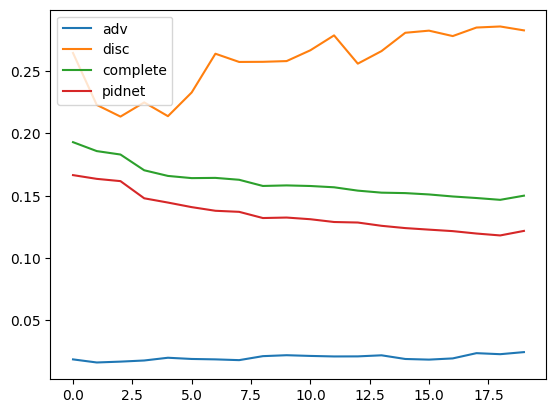

In [17]:
# PLOT LOSSES using plot_losses
import matplotlib.pyplot as plt
plt.plot(plot_losses['adv'], label='adv')
plt.plot(plot_losses['disc'], label='disc')
plt.plot(plot_losses['complete'], label='complete')
plt.plot(plot_losses['pidnet'], label='pidnet')
plt.legend()
plt.show()

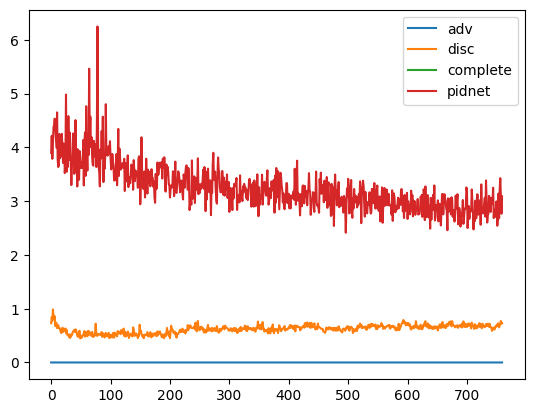

In [18]:
# PLOT BATCH LOSSES using batch_losses
import matplotlib.pyplot as plt
plt.plot(batch_losses['adv'], label='adv')
plt.plot(batch_losses['disc'], label='disc')
plt.plot(batch_losses['complete'], label='complete')
plt.plot(batch_losses['pidnet'], label='pidnet')
plt.legend()
plt.show()

# TEST

### Remove all models in local

In [19]:
# import os

# all_local_files = os.listdir('.')
# all_local_models = [f for f in all_local_files if f.endswith('.pth')]

# for model_name in all_local_models:
#     os.remove(model_name)
#     print(f"Removed {model_name}")

### Copy Some Models From MyDrive/LoveDA

In [20]:
# Run the first cell pls
import os

BASE_PATH = "/content/drive/MyDrive/LoveDA/"

if TEST_MODELS_FROM_MYDRIVE_TOO:
  all_mydrive = os.listdir(BASE_PATH)
  all_models = [f for f in all_mydrive if f.endswith('.pth')]
  models_of_interest = [f for f in all_models if INTEREST in f]
  for model_name in models_of_interest:
      if not os.path.exists(model_name):
        print(f"Copying {model_name} locally from MyDrive")
        # !cp {BASE_PATH+model_name} .

In [21]:
!pip install torchmetrics ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [22]:
from torchmetrics import Accuracy
from tqdm import tqdm
import time
import ptflops
import os

DEVICE = 'cuda'
TYPE = 'Test'
# WARNING: YOU MAY DECIDE TO OVVERIDE THE CHOOSE_TRANSFORM, BUT BE CAREFUL. BE SURE THE MODEL YOU'RE USING IS THE CORRECT ONE
CHOOSE_TRANSFORM = 'Resize'

# Create unweighted models
model = get_seg_model(cfg, imgnet_pretrained=False)
# disc_model = Discriminator(len(LABEL_MAP))

# Load weights
model_name_pattern = 'best_DA_model' # for starters, use 'best_DA_model' for this step, and just 'best_model' for non DA models
disc_model_name_pattern = 'best_disc_model'

# find filenames that start with model_name_pattern using os
model_files_paths = [f for f in os.listdir('.') if f.startswith(model_name_pattern)]
# disc_model_files_paths = [f for f in os.listdir('.') if f.startswith(disc_model_name_pattern)]
print(model_files_paths)

for model_file_path in model_files_paths:
    best_model = torch.load(model_file_path, weights_only=True)
    # best_disc_model = torch.load(disc_model_file_path, weights_only=True)

    model.load_state_dict(best_model)
    model = model.to(DEVICE)
    # disc_model.load_state_dict(best_disc_model)
    # disc_model = disc_model.to(DEVICE)

    accuracy, mIoU = True, True

    TARGETs = ['Urban', 'Rural']

    for TARGET in TARGETs:
        if TARGET == 'Urban': # Here we just validate on less images if URBAN, as it's not the focus of step 3b. Use Train instead of Validation for a 0.8 split instead of 0.2
            target_type = 'Validation'
        elif TARGET == 'Rural': # While we take the entirety of the Rural folder in case of Rural
            #target_type = 'ActualTest'
            target_type = 'Validation'
        else:
            raise ValueError("TARGET must be 'Urban' or 'Rural'")



        if CHOOSE_TRANSFORM == 'RandomCropOrResize':
            test_augmentation = AUGMENTATIONS['RandomCrop512']
        elif CHOOSE_TRANSFORM == 'RandomCropXXX':
            test_augmentation = AUGMENTATIONS['None']
        elif CHOOSE_TRANSFORM == 'Jitter':
            test_augmentation = AUGMENTATIONS['None']
        elif CHOOSE_TRANSFORM == 'GaussianBlur':
            test_augmentation = AUGMENTATIONS['None']
        else:
            test_augmentation = AUGMENTATIONS[CHOOSE_TRANSFORM]

        test_dataset = LoveDADataset(baseTransform=test_augmentation, augTransforms=None, split=TARGET, type=target_type, useBoundaries=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)

        #### TEST LOOP
        model.eval()
        print(f"Testing model={model_file_path} on domain={TARGET} on a {target_type} split")

        # Latency
        with torch.no_grad():
            start_time = time.time()
            for _ in range(100):
                _ = model(torch.randn(1, 3, RESIZE, RESIZE).to(DEVICE))
            end_time = time.time()
        latency = (end_time - start_time) / 100
        print(f"Latency: {latency:.4f} seconds")

        # FLOPs
        macs, _ = ptflops.get_model_complexity_info(model,
            (3, RESIZE, RESIZE), as_strings=False,
            print_per_layer_stat=False, verbose=False)
        flops = macs * 2  # MACs perform two FLOPs
        print("FLOPs:", flops)

        # Number of parameters
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total number of parameters: {total_params}")

        if TYPE == 'Test':
            with torch.no_grad():
                total_union = torch.zeros(NUM_CLASSES).to(DEVICE)
                total_intersection = torch.zeros(NUM_CLASSES).to(DEVICE)
                meter = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(DEVICE)
                for (batch) in tqdm(test_loader):
                    ### Extract input
                    images, masks, img_path, bd_gts = batch
                    images = images.float().to(DEVICE)
                    masks = masks.to(DEVICE)

                    ### ===> Forward, Upscale, Compute Losses
                    ## Forward
                    outputs = model(images)

                    ## Upscale (bilinear interpolation - not learned)
                    h, w = masks.size(1), masks.size(2)
                    ph, pw = outputs[0].size(2), outputs[0].size(3)
                    if ph != h or pw != w:
                        for i in range(len(outputs)):
                            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

                    # Output 1 is the prediction

                    # Shape: NBATCHES x classes x h x w
                    class_indices = torch.argmax(outputs[1], dim=1)  # Shape: NBATCHES x h x w

                    if accuracy:
                    # Create a mask for valid targets (where target is not -1)
                        valid_mask = (masks != -1)  # Mask of shape: NBATCHES x h x w
                        # Apply the mask to ignore -1 targets when updating the accuracy metric
                        meter.update(class_indices[valid_mask], masks[valid_mask])

                    if mIoU:
                        for predicted, target in zip(class_indices, masks):
                            for i in range(NUM_CLASSES):
                                total_intersection[i] += torch.sum(torch.logical_and(predicted == i, target == i))
                                total_union[i] += torch.sum(torch.logical_or(predicted == i, target == i))

        if accuracy:
            accuracy = meter.compute()
            print(f'\nAccuracy on the target domain: {100 * accuracy:.2f}%')

        if mIoU:
            intersection_over_union = total_intersection / total_union

            # Per class IoU
            for i, iou in enumerate(intersection_over_union):
                class_name = list(LABEL_MAP.keys())[list(LABEL_MAP.values()).index(i)]  # Get the class name from LABEL_MAP
                print(f'{class_name} IoU: {iou:.4f}')

            mIoU = torch.mean(intersection_over_union)
            print(f'\nmIoU on the {TARGET} domain: {mIoU}')

        print("========================================================================")

    if TEST_ONLY_ON_BEST:
        break


<ipython-input-8-793b5191e8fb>:204: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')


['best_DA_model_LA=0.0001_LD=0.1_LRdisc=0.0005_usespike=False_s=0_spid=0__bestmIoUUrban.pth', 'best_DA_model_LA=0.0001_LD=0.1_LRdisc=0.0005_usespike=False_s=0_spid=0.pth_20.pth']
Dataset size: 232
Testing model=best_DA_model_LA=0.0001_LD=0.1_LRdisc=0.0005_usespike=False_s=0_spid=0__bestmIoUUrban.pth on domain=Urban on a Validation split
Latency: 0.0216 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 9/9 [00:07<00:00,  1.21it/s]



Accuracy on the target domain: 70.66%
Background IoU: 0.5355
Building IoU: 0.5585
Road IoU: 0.5882
Water IoU: 0.6440
Barren IoU: 0.4175
Forest IoU: 0.3625
Agricultural IoU: 0.2900

mIoU on the Urban domain: 0.48517242074012756
Dataset size: 274
Testing model=best_DA_model_LA=0.0001_LD=0.1_LRdisc=0.0005_usespike=False_s=0_spid=0__bestmIoUUrban.pth on domain=Rural on a Validation split
Latency: 0.0198 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 11/11 [00:08<00:00,  1.26it/s]



Accuracy on the target domain: 51.87%
Background IoU: 0.3617
Building IoU: 0.2929
Road IoU: 0.1852
Water IoU: 0.4554
Barren IoU: 0.0871
Forest IoU: 0.4116
Agricultural IoU: 0.3850

mIoU on the Rural domain: 0.31127461791038513
Dataset size: 232
Testing model=best_DA_model_LA=0.0001_LD=0.1_LRdisc=0.0005_usespike=False_s=0_spid=0.pth_20.pth on domain=Urban on a Validation split
Latency: 0.0205 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]



Accuracy on the target domain: 69.89%
Background IoU: 0.5562
Building IoU: 0.5548
Road IoU: 0.5784
Water IoU: 0.4303
Barren IoU: 0.2943
Forest IoU: 0.3003
Agricultural IoU: 0.3298

mIoU on the Urban domain: 0.4348663091659546
Dataset size: 274
Testing model=best_DA_model_LA=0.0001_LD=0.1_LRdisc=0.0005_usespike=False_s=0_spid=0.pth_20.pth on domain=Rural on a Validation split
Latency: 0.0204 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


 91%|█████████ | 10/11 [00:08<00:00,  1.21it/s]


KeyboardInterrupt: 